In [71]:
# base
import shap
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm
from sklearn.linear_model import Lasso
import joblib

# Важная настройка для корректной настройки pipeline!
import sklearn
sklearn.set_config(transform_output="pandas")

# Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.base import BaseEstimator, TransformerMixin

# Preprocessing
from sklearn.impute import SimpleImputer
from sklearn.decomposition import PCA
from sklearn.preprocessing import OneHotEncoder, StandardScaler, RobustScaler, MinMaxScaler, OrdinalEncoder, TargetEncoder
from sklearn.model_selection import GridSearchCV, KFold

# for model learning
from sklearn.model_selection import train_test_split, RandomizedSearchCV, cross_val_score

#models
from sklearn.neighbors import KNeighborsClassifier, RadiusNeighborsClassifier
from sklearn.linear_model import LogisticRegression, LinearRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, VotingClassifier, BaggingClassifier
from catboost import CatBoostRegressor
from sklearn.ensemble import RandomForestRegressor

# Metrics
from sklearn.metrics import accuracy_score
from scipy.stats import ttest_ind

# tunning hyperparamters model
import optuna

from sklearn.feature_selection import f_regression, chi2

Загрузка и обьеденение датасета

In [72]:
X_train = pd.read_csv('/Users/igor/ds_bootcamp/ds-phase-1/ds_pj1/Anticipators_project/train.csv')
X_test = pd.read_csv('/Users/igor/ds_bootcamp/ds-phase-1/ds_pj1/Anticipators_project/test.csv')
pd.set_option('display.max_columns', None)
all_data =pd.concat([X_train, X_test])
all_data

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,LandSlope,Neighborhood,Condition1,Condition2,BldgType,HouseStyle,OverallQual,OverallCond,YearBuilt,YearRemodAdd,RoofStyle,RoofMatl,Exterior1st,Exterior2nd,MasVnrType,MasVnrArea,ExterQual,ExterCond,Foundation,BsmtQual,BsmtCond,BsmtExposure,BsmtFinType1,BsmtFinSF1,BsmtFinType2,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,Heating,HeatingQC,CentralAir,Electrical,1stFlrSF,2ndFlrSF,LowQualFinSF,GrLivArea,BsmtFullBath,BsmtHalfBath,FullBath,HalfBath,BedroomAbvGr,KitchenAbvGr,KitchenQual,TotRmsAbvGrd,Functional,Fireplaces,FireplaceQu,GarageType,GarageYrBlt,GarageFinish,GarageCars,GarageArea,GarageQual,GarageCond,PavedDrive,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,Inside,Gtl,CollgCr,Norm,Norm,1Fam,2Story,7,5,2003,2003,Gable,CompShg,VinylSd,VinylSd,BrkFace,196.0,Gd,TA,PConc,Gd,TA,No,GLQ,706.0,Unf,0.0,150.0,856.0,GasA,Ex,Y,SBrkr,856,854,0,1710,1.0,0.0,2,1,3,1,Gd,8,Typ,0,NaN,Attchd,2003.0,RFn,2.0,548.0,TA,TA,Y,0,61,0,0,0,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500.0
1,2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,FR2,Gtl,Veenker,Feedr,Norm,1Fam,1Story,6,8,1976,1976,Gable,CompShg,MetalSd,MetalSd,NaN,0.0,TA,TA,CBlock,Gd,TA,Gd,ALQ,978.0,Unf,0.0,284.0,1262.0,GasA,Ex,Y,SBrkr,1262,0,0,1262,0.0,1.0,2,0,3,1,TA,6,Typ,1,TA,Attchd,1976.0,RFn,2.0,460.0,TA,TA,Y,298,0,0,0,0,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500.0
2,3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,Inside,Gtl,CollgCr,Norm,Norm,1Fam,2Story,7,5,2001,2002,Gable,CompShg,VinylSd,VinylSd,BrkFace,162.0,Gd,TA,PConc,Gd,TA,Mn,GLQ,486.0,Unf,0.0,434.0,920.0,GasA,Ex,Y,SBrkr,920,866,0,1786,1.0,0.0,2,1,3,1,Gd,6,Typ,1,TA,Attchd,2001.0,RFn,2.0,608.0,TA,TA,Y,0,42,0,0,0,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500.0
3,4,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,Corner,Gtl,Crawfor,Norm,Norm,1Fam,2Story,7,5,1915,1970,Gable,CompShg,Wd Sdng,Wd Shng,NaN,0.0,TA,TA,BrkTil,TA,Gd,No,ALQ,216.0,Unf,0.0,540.0,756.0,GasA,Gd,Y,SBrkr,961,756,0,1717,1.0,0.0,1,0,3,1,Gd,7,Typ,1,Gd,Detchd,1998.0,Unf,3.0,642.0,TA,TA,Y,0,35,272,0,0,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000.0
4,5,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,FR2,Gtl,NoRidge,Norm,Norm,1Fam,2Story,8,5,2000,2000,Gable,CompShg,VinylSd,VinylSd,BrkFace,350.0,Gd,TA,PConc,Gd,TA,Av,GLQ,655.0,Unf,0.0,490.0,1145.0,GasA,Ex,Y,SBrkr,1145,1053,0,2198,1.0,0.0,2,1,4,1,Gd,9,Typ,1,TA,Attchd,2000.0,RFn,3.0,836.0,TA,TA,Y,192,84,0,0,0,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1454,2915,160,RM,21.0,1936,Pave,NaN,Reg,Lvl,AllPub,Inside,Gtl,MeadowV,Norm,Norm,Twnhs,2Story,4,7,1970,1970,Gable,CompShg,CemntBd,CmentBd,NaN,0.0,TA,TA,CBlock,TA,TA,No,Unf,0.0,Unf,0.0,546.0,546.0,GasA,Gd,Y,SBrkr,546,546,0,1092,0.0,0.0,1,1,3,1,TA,5,Typ,0,NaN,NaN,NaN,NaN,0.0,0.0,NaN,NaN,Y,0,0,0,0,0,0,NaN,NaN,NaN,0,6,2006,WD,Normal,NaN
1455,2916,160,RM,21.0,1894,Pave,NaN,Reg,Lvl,AllPub,Inside,Gtl,MeadowV,Norm,Norm,TwnhsE,2Story,4,5,1970,1970,Gable,CompShg,CemntBd,CmentBd,NaN,0.0,TA,TA,CBlock,TA,TA,No,Rec,252.0,Unf,0.0,294.0,546.0,GasA,TA,Y,SBrkr,546,546,0,1092,0.0,0.0,1,1,3,1,TA,6,Typ,0,NaN,CarPort,1970.0,Unf,1.0,286.0,TA,TA,Y,0,24,0,0,0,0,NaN,NaN,NaN,0,4,2006,WD,Abnorml,NaN
1456,2917,20,RL,160.0,20000,Pave,NaN,Reg,Lvl,AllPub,Inside,Gtl,Mitchel,Norm,Norm,1Fam,1Story,5,7,1960,1996,Gable,CompShg,VinylSd,VinylSd,NaN,0.0,TA,TA,CBlock,TA,TA,No,ALQ,1224.0,Unf,0.0,0.0,1224.0,GasA,Ex,Y,SBrkr,1224,0,0,1224,1.0,0.0,1,0,4,1,TA,7,Typ,1,TA,Detchd,1960.0,Unf,2.0,576.0,TA,TA,Y,474,0,0,0,0,0,NaN,NaN,NaN,0,9,2006,WD,Abnorml,NaN
1457,2918,85,RL,62.0,10441,Pave,NaN,Reg,Lvl,AllPub,Inside,Gtl,Mitchel,Norm,

Удаление нанов

In [73]:
cat_feat_nan = ['Alley', 'BsmtCond', 'BsmtQual', 'BsmtExposure', 'BsmtFinType1', 
                'BsmtFinType2', 'FireplaceQu', 'GarageType', 'GarageFinish', 
                'GarageQual', 'GarageCond', 'PoolQC', 'Fence', 'MiscFeature', 'MasVnrType']
all_data[cat_feat_nan] = all_data[cat_feat_nan].fillna('without')


all_data['LotFrontage'] = all_data['LotFrontage'].fillna(0)
all_data['MasVnrArea'] = all_data['MasVnrArea'].fillna(0)
all_data['Electrical'] = all_data['Electrical'].fillna(all_data['Electrical'].mode()[0])

all_data['GarageYrBlt'] = all_data['GarageYrBlt'].fillna(all_data['YearBuilt'])


mean_fill = ['BsmtFinSF1', 'BsmtFinSF2', 'BsmtUnfSF', 'TotalBsmtSF', 'GarageArea']
mode_fill = ['MSZoning', 'Utilities', 'Exterior1st', 'Exterior2nd', 'BsmtFullBath', 'BsmtHalfBath', 'KitchenQual', 'Functional', 'GarageCars', 'SaleType']

all_data[mean_fill] = all_data[mean_fill].fillna(all_data[mean_fill].mode().iloc[0])
all_data[mode_fill] = all_data[mode_fill].fillna(all_data[mode_fill].mode().iloc[0])



print(all_data.isnull().sum()[all_data.isnull().sum() > 0])

SalePrice    1459
dtype: int64


Графики
распределение цен на дома (таргета)
сабплот с гистограмами числовых признаков
 сабплот с барплотами категориальных признаков
матрица корреляций

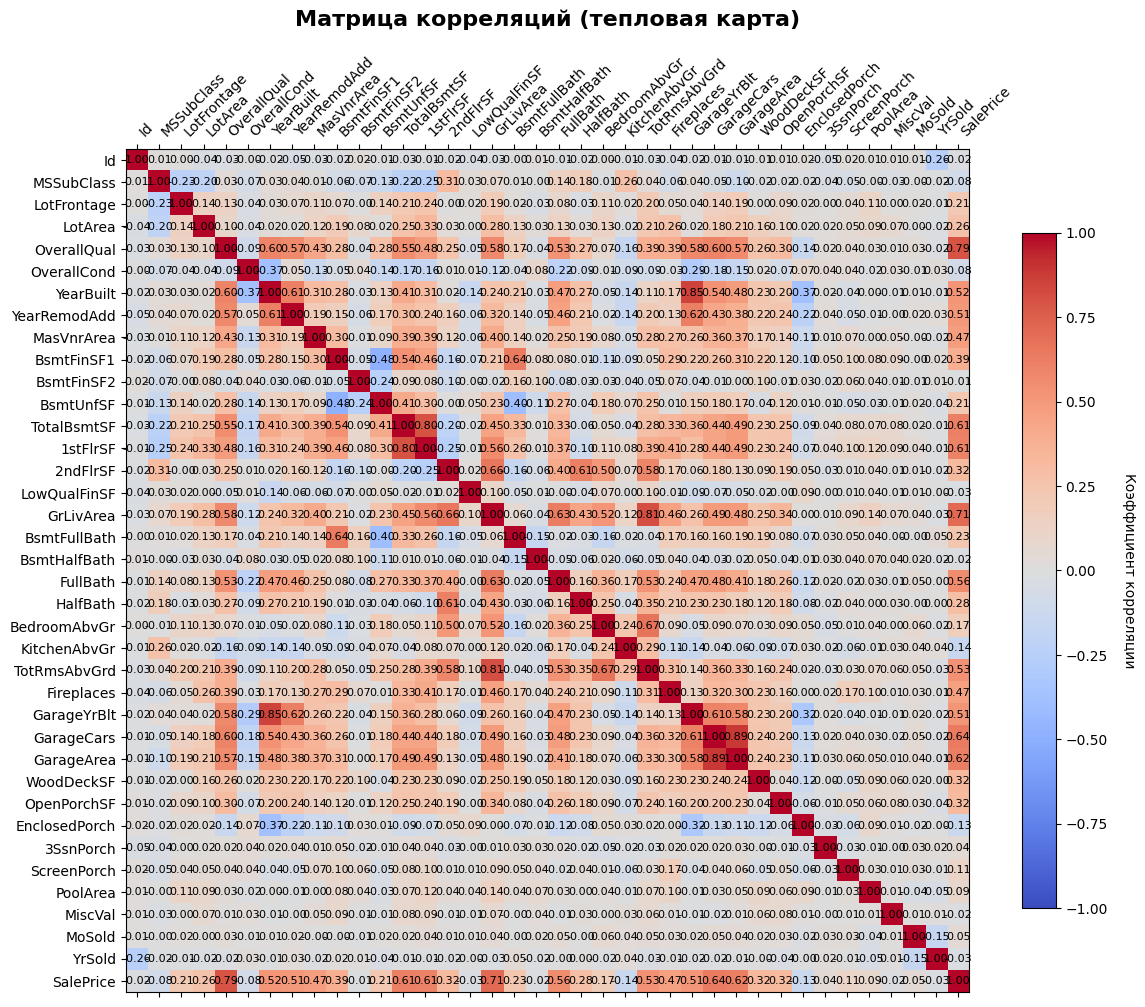

In [74]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Вычисляем корреляционную матрицу
corr_matrix = all_data.select_dtypes(include=[np.number]).corr()

# Создаём фигуру и оси
fig, ax = plt.subplots(figsize=(12, 10))


# Рисуем тепловую карту через matshow
im = ax.matshow(corr_matrix, cmap='coolwarm', vmin=-1, vmax=1)


# Добавляем значения корреляций в ячейки
for i in range(corr_matrix.shape[0]):
    for j in range(corr_matrix.shape[1]):
        ax.text(j, i, f'{corr_matrix.iloc[i, j]:.2f}',
                ha='center', va='center', color='black', fontsize=8)


# Настраиваем метки
ax.set_xticks(range(corr_matrix.shape[1]))
ax.set_yticks(range(corr_matrix.shape[0]))
ax.set_xticklabels(corr_matrix.columns, rotation=45, ha='left')
ax.set_yticklabels(corr_matrix.columns)


# Добавляем цветную шкалу (легенду)
cbar = plt.colorbar(im, ax=ax, shrink=0.8)
cbar.set_label('Коэффициент корреляции', rotation=270, labelpad=20)


# Заголовок
plt.title('Матрица корреляций (тепловая карта)', fontsize=16, fontweight='bold', pad=20)


# Улучшаем расположение элементов
plt.tight_layout()
plt.show()

Результат:
Overquality очень хорошо предсказывает таргет
Garageyearbuild на 85 проц повторяет Yearbuild
Total bsmtSF кандидат на выкид - колинеарный с площадьми первого этажа и пр
totalrmsabvgrd выкидываем так как отражает жилую площадь без подвала
Garage cars выкинуть отражает garage area


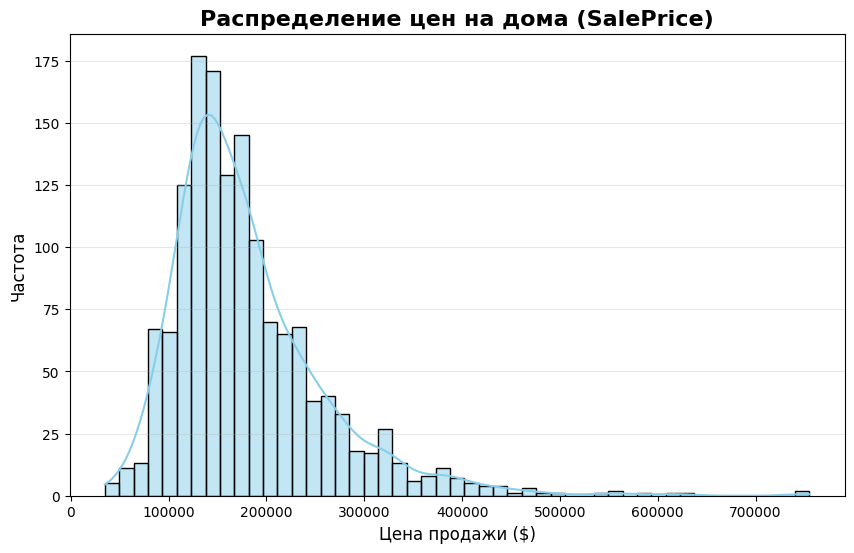

In [75]:
# Распределение целевой переменной (цены на дома)

plt.figure(figsize=(10, 6))
sns.histplot(all_data['SalePrice'], kde=True, color='skyblue')
plt.title('Распределение цен на дома (SalePrice)', fontsize=16, fontweight='bold')
plt.xlabel('Цена продажи ($)', fontsize=12)
plt.ylabel('Частота', fontsize=12)
plt.grid(axis='y', alpha=0.3)
plt.show()

Распределение цен Точно есть выброс по цене выше 500 000  заменим на среднюю

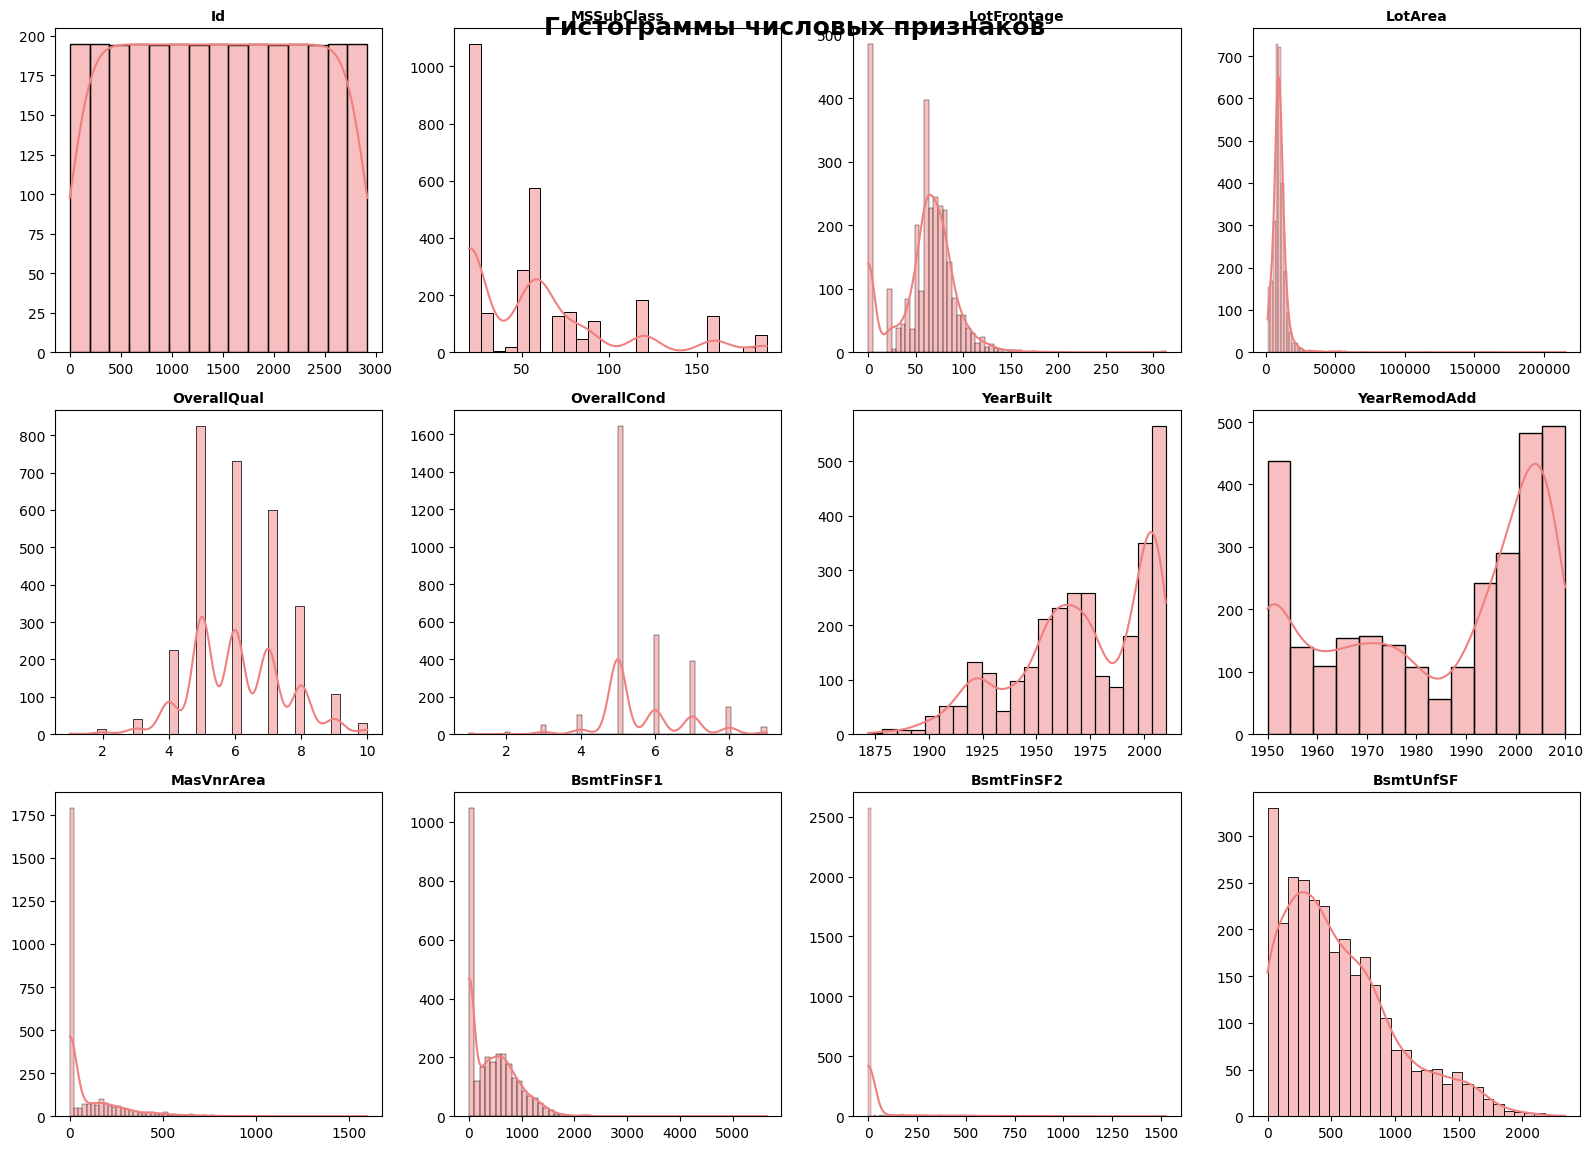

In [76]:
# Сабплот с гистограммами числовых признаков

# Выбираем числовые столбцы (исключая целевую переменную)
numeric_cols = all_data.select_dtypes(include=[np.number]).columns.tolist()
numeric_cols.remove('SalePrice')  # убираем целевую переменную, если есть

# Ограничим число признаков для наглядности (например, первые 12)
numeric_cols = numeric_cols[:12]

# Создаём сабплот
fig, axes = plt.subplots(3, 4, figsize=(16, 12))
axes = axes.ravel()  # превращаем матрицу осей в массив

for i, col in enumerate(numeric_cols):
    if i < len(axes):
        sns.histplot(all_data[col].dropna(), ax=axes[i], color='lightcoral', kde=True)
        axes[i].set_title(f'{col}', fontsize=10, fontweight='bold')
        axes[i].set_xlabel('')
        axes[i].set_ylabel('')

# Удаляем пустые подграфики
for j in range(len(numeric_cols), len(axes)):
    fig.delaxes(axes[j])

plt.suptitle('Гистограммы числовых признаков', fontsize=18, fontweight='bold', y=0.95)
plt.tight_layout()
plt.show()



lotfrontage мало влияет
lotarea рубим больше 50 000


/var/folders/2j/gndh6xkj3yg409hz8hmf3p_c0000gn/T/ipykernel_33494/1174728688.py:17: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=counts.index, y=counts.values, ax=axes[i], palette='viridis')
/var/folders/2j/gndh6xkj3yg409hz8hmf3p_c0000gn/T/ipykernel_33494/1174728688.py:17: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=counts.index, y=counts.values, ax=axes[i], palette='viridis')
/var/folders/2j/gndh6xkj3yg409hz8hmf3p_c0000gn/T/ipykernel_33494/1174728688.py:17: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=counts.index, y=counts.values,

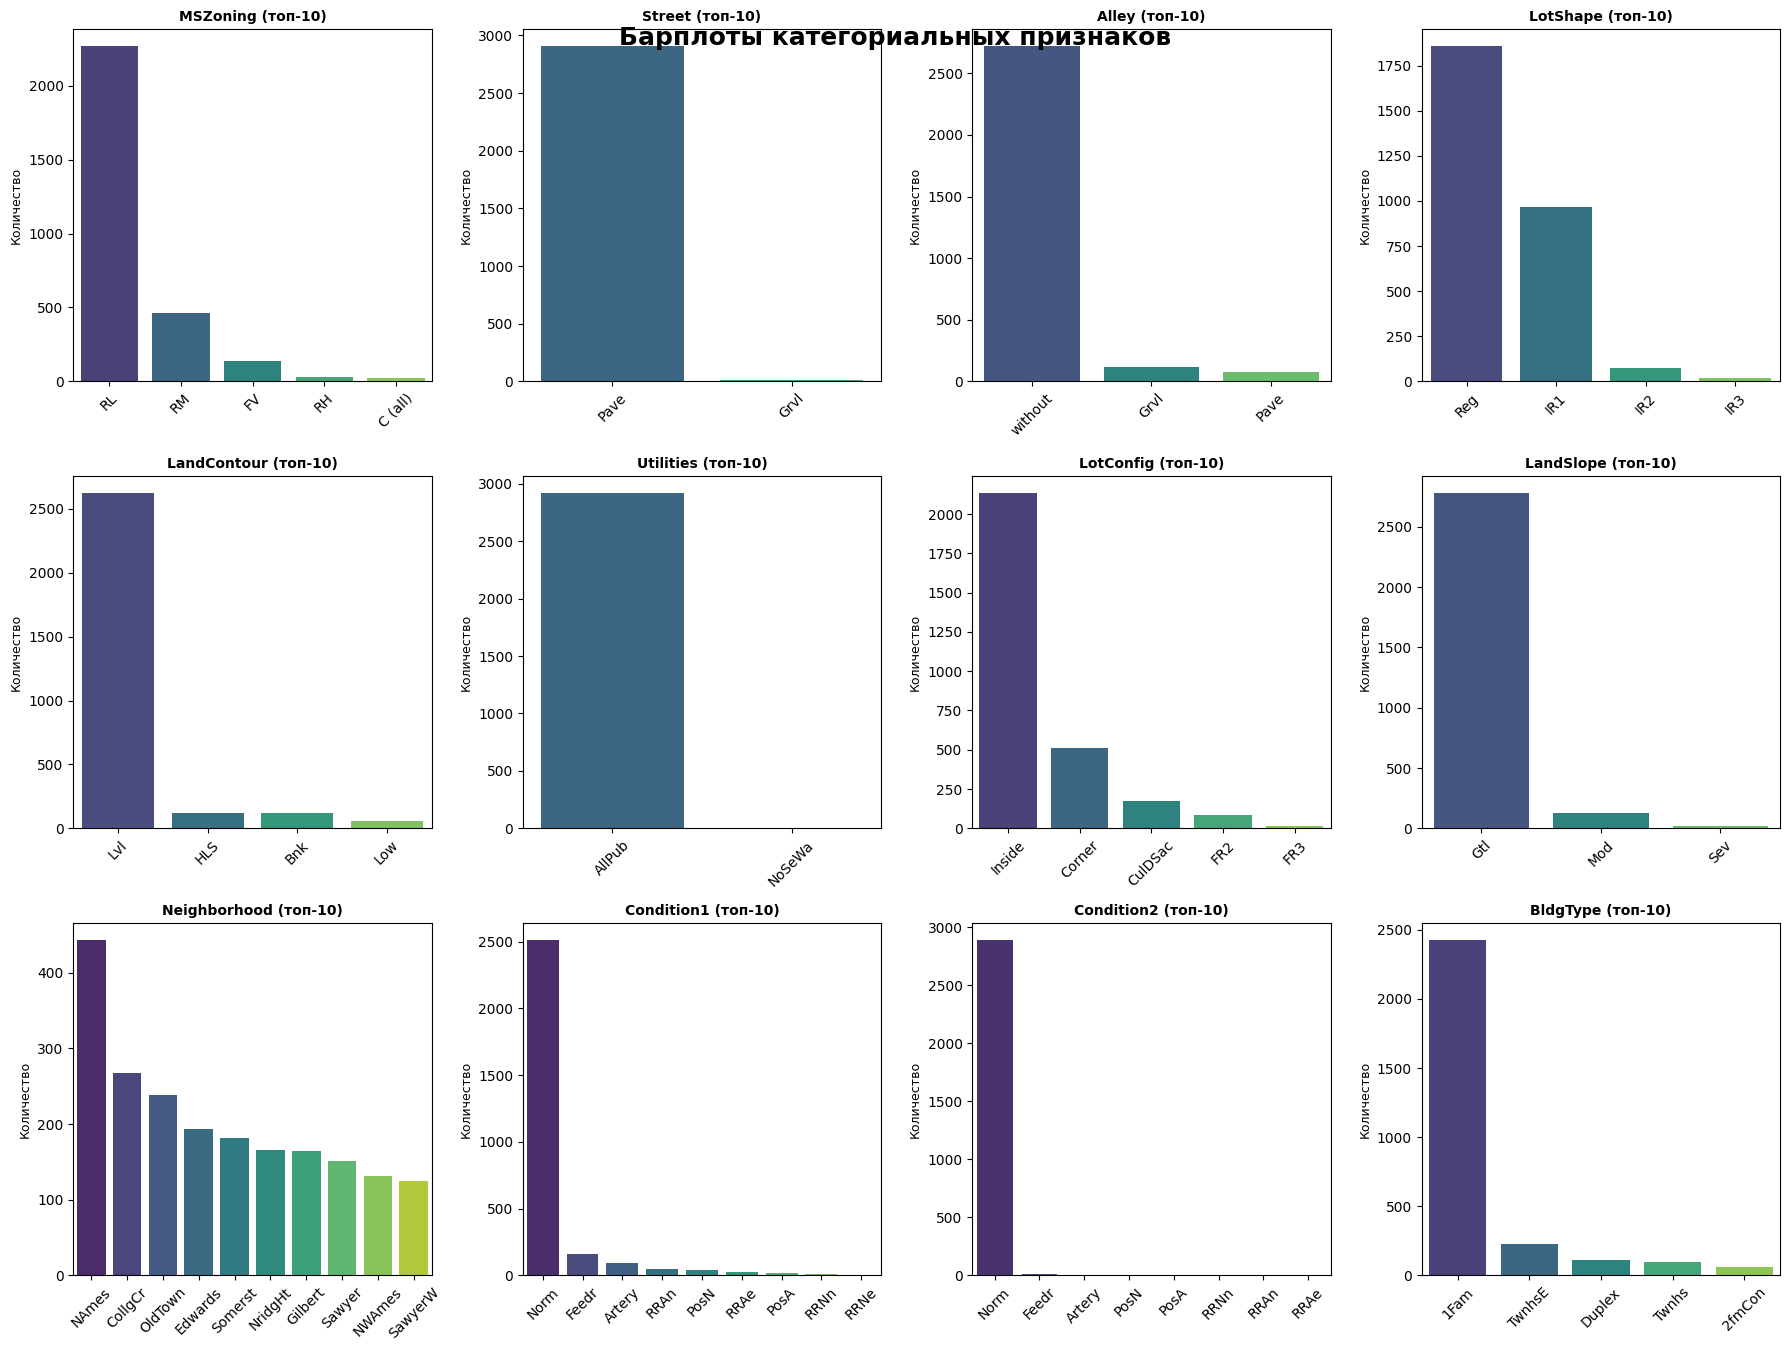

In [77]:
# Сабплот с барплотами категориальных признаков

# Выбираем категориальные столбцы
categorical_cols = all_data.select_dtypes(include=['object']).columns.tolist()

# Ограничим до 12 признаков для наглядности
categorical_cols = categorical_cols[:12]

# Создаём сабплот
fig, axes = plt.subplots(3, 4, figsize=(18, 14))
axes = axes.ravel()

for i, col in enumerate(categorical_cols):
    if i < len(axes):
        # Считаем частоты категорий
        counts = all_data[col].value_counts().head(10)  # топ-10 категорий
        sns.barplot(x=counts.index, y=counts.values, ax=axes[i], palette='viridis')
        axes[i].set_title(f'{col} (топ-10)', fontsize=10, fontweight='bold')
        axes[i].set_xlabel('')
        axes[i].set_ylabel('Количество', fontsize=9)
        axes[i].tick_params(axis='x', rotation=45)

# Удаляем пустые подграфики
for j in range(len(categorical_cols), len(axes)):
    fig.delaxes(axes[j])


plt.suptitle('Барплоты категориальных признаков', fontsize=18, fontweight='bold', y=0.95)
plt.tight_layout()
plt.show()

мало информации дает

Разделяем датасет

In [78]:
X_train = all_data.iloc[:1460]
y_train = X_train['SalePrice']
X_train = X_train.drop('SalePrice', axis=1)

X_valid = all_data.iloc[1460:].drop('SalePrice', axis=1)



Разделяем названия колонок на енкодеры

In [79]:
a = X_train.select_dtypes(include='object')
one_hot_coder = a.loc[:, a.nunique() <= 3].columns.to_list()
target_coder = a.loc[:, a.nunique() > 3 ].columns.to_list()



In [80]:
preprocessor = ColumnTransformer(
    [
        ('ohe_hot_coder', OneHotEncoder(sparse_output=False), one_hot_coder),
        ('target_coder', TargetEncoder(), target_coder),
        
    ],
    verbose_feature_names_out = False,
    remainder = 'passthrough'
)

model = LinearRegression()

ml1_pipeline = Pipeline(
    (
        ('preprocessor', preprocessor),
        ('scaler', StandardScaler()),
        ('model', model)   
    )
)

y_train_log = np.log1p(y_train)


In [81]:
ml1_pipeline.fit(X_train, y_train_log)

,steps,"[('preprocessor', ...), ('scaler', ...), ...]"
,transform_input,None
,memory,None
,verbose,False
,transformers,"[('ohe_hot_coder', ...), ('target_coder', ...)]"
,remainder,'passthrough'
,sparse_threshold,0.3
,n_jobs,None
,transformer_weights,None
,verbose,False
,verbose_feature_names_out,False


In [82]:
y_pred_log = ml1_pipeline.predict(X_valid)
y_pred =  np.expm1(y_pred_log)
y_pred

array([106077.58096812, 148025.51640451, 164431.77719553, ...,
       161993.34545725, 112932.97366894, 216200.34657352], shape=(1459,))

In [83]:


# Предсказание и обратное преобразование
y_pred = pd.Series(
    np.expm1(ml1_pipeline.predict(X_valid)),
    index=X_valid.index,
    name='SalePrice'
)

# Вывод первых 10 предсказаний
from sklearn.metrics import mean_squared_error

# Так как y_train_log = log1p(y_train), предсказания тоже в log1p-шкале
y_pred_log = ml1_pipeline.predict(X_train)

# RMSLE = RMSE на логарифмах
rmsle = np.sqrt(mean_squared_error(y_train_log, y_pred_log))
print(f"RMSLE: {rmsle:.4f}")



RMSLE: 0.1240


In [84]:


y_pred = pd.Series(
    np.expm1(ml1_pipeline.predict(X_valid)),
    index=X_valid['Id'],  # ← используем реальные Id из данных
    name='SalePrice'
)

In [85]:
y_pred.to_csv('baseline_result.csv')

# Kagle 0.139

**Фильтрация фитч**

In [86]:
numeric_cols = all_data.select_dtypes(include=[np.number]).columns.tolist()
lst = all_data[numeric_cols].corr()['SalePrice'][:-1].sort_values(key=lambda x: abs(x), ascending=False)

cor_result = ['Id', 'MiscVal', 'BsmtHalfBath', 'BsmtFinSF2', 'MoSold', '3SsnPorch', 'YrSold', 'LowQualFinSF']

lst

OverallQual      0.790982
GrLivArea        0.708624
GarageCars       0.640409
GarageArea       0.623431
TotalBsmtSF      0.613581
1stFlrSF         0.605852
FullBath         0.560664
TotRmsAbvGrd     0.533723
YearBuilt        0.522897
GarageYrBlt      0.508043
YearRemodAdd     0.507101
MasVnrArea       0.472614
Fireplaces       0.466929
BsmtFinSF1       0.386420
WoodDeckSF       0.324413
2ndFlrSF         0.319334
OpenPorchSF      0.315856
HalfBath         0.284108
LotArea          0.263843
BsmtFullBath     0.227122
BsmtUnfSF        0.214479
LotFrontage      0.209624
BedroomAbvGr     0.168213
KitchenAbvGr    -0.135907
EnclosedPorch   -0.128578
ScreenPorch      0.111447
PoolArea         0.092404
MSSubClass      -0.084284
OverallCond     -0.077856
MoSold           0.046432
3SsnPorch        0.044584
YrSold          -0.028923
LowQualFinSF    -0.025606
Id              -0.021917
MiscVal         -0.021190
BsmtHalfBath    -0.016844
BsmtFinSF2      -0.011378
Name: SalePrice, dtype: float64

In [87]:
# Выбираем числовые столбцы
numeric_cols = all_data.select_dtypes(include=[np.number])

# Отделяем признаки и целевую переменную
X = numeric_cols.drop(columns=['SalePrice'])
y = numeric_cols['SalePrice']

# Удаляем строки с пропусками (или заранее обработайте NaN!)
# Важно: f_regression не работает с NaN!
mask = ~(X.isna().any(axis=1) | y.isna())
X_clean = X.loc[mask]
y_clean = y.loc[mask]

# Вычисляем p-value для каждого признака
f_stats, p_values = f_regression(X_clean, y_clean)

# Создаём Series: признак -> p-value
pval_series = pd.Series(p_values, index=X.columns).sort_values()

print(pval_series.to_string())

res = ['MoSold', '3SsnPorch', 'YrSold', 'LowQualFinSF', 'Id', 'MiscVal', 'BsmtHalfBath', 'BsmtFinSF2']
   


OverallQual      2.185675e-313
GrLivArea        4.518034e-223
GarageCars       2.498644e-169
GarageArea       5.265038e-158
TotalBsmtSF      9.484229e-152
1stFlrSF         5.394711e-147
FullBath         1.236470e-121
TotRmsAbvGrd     2.772281e-108
YearBuilt        2.990229e-103
GarageYrBlt       1.234823e-96
YearRemodAdd      3.164948e-96
MasVnrArea        4.100461e-82
Fireplaces        6.141487e-80
BsmtFinSF1        3.394110e-53
WoodDeckSF        3.972217e-37
2ndFlrSF          5.764335e-36
OpenPorchSF       3.493374e-35
HalfBath          1.650473e-28
LotArea           1.123139e-24
BsmtFullBath      1.550344e-18
BsmtUnfSF         1.182976e-16
LotFrontage       5.824303e-16
BedroomAbvGr      9.927497e-11
KitchenAbvGr      1.860426e-07
EnclosedPorch     8.255770e-07
ScreenPorch       1.972140e-05
PoolArea          4.073490e-04
MSSubClass        1.266472e-03
OverallCond       2.912351e-03
MoSold            7.612758e-02
3SsnPorch         8.858170e-02
YrSold            2.694132e-01
LowQualF

In [88]:



preprocessor = ColumnTransformer(
    [
        ('ohe_hot_coder', OneHotEncoder(sparse_output=False), one_hot_coder),
        ('target_coder', TargetEncoder(), target_coder),
        
    ],
    verbose_feature_names_out = False,
    remainder = 'passthrough'
)

model = CatBoostRegressor(iterations=300, learning_rate=0.1, random_seed=123)

ml2_pipeline = Pipeline(
    (
        ('preprocessor', preprocessor),
        ('scaler', StandardScaler()),
        ('model', model)   
    )
)

y_train_log = np.log1p(y_train)


ml2_pipeline.fit(X_train, y_train_log)



# Предсказание и обратное преобразование
y_pred = pd.Series(
    np.expm1(ml1_pipeline.predict(X_valid)),
    index=X_valid.index,
    name='SalePrice'
)

# Вывод первых 10 предсказаний
from sklearn.metrics import mean_squared_error

# Так как y_train_log = log1p(y_train), предсказания тоже в log1p-шкале
y_pred_log = ml1_pipeline.predict(X_train)

# RMSLE = RMSE на логарифмах
rmsle = np.sqrt(mean_squared_error(y_train_log, y_pred_log))
print(f"RMSLE: {rmsle:.4f}")


0:	learn: 0.3742090	total: 1.15ms	remaining: 342ms
1:	learn: 0.3497923	total: 2.53ms	remaining: 377ms
2:	learn: 0.3280728	total: 3.43ms	remaining: 339ms
3:	learn: 0.3081123	total: 4.6ms	remaining: 340ms
4:	learn: 0.2914083	total: 5.65ms	remaining: 333ms
5:	learn: 0.2744660	total: 6.72ms	remaining: 329ms
6:	learn: 0.2606090	total: 7.77ms	remaining: 325ms
7:	learn: 0.2483177	total: 8.78ms	remaining: 320ms
8:	learn: 0.2358870	total: 9.79ms	remaining: 317ms
9:	learn: 0.2251273	total: 10.8ms	remaining: 314ms
10:	learn: 0.2152817	total: 11.9ms	remaining: 312ms
11:	learn: 0.2064065	total: 12.9ms	remaining: 310ms
12:	learn: 0.1984948	total: 13.9ms	remaining: 308ms
13:	learn: 0.1912940	total: 14.9ms	remaining: 305ms
14:	learn: 0.1843019	total: 15.9ms	remaining: 302ms
15:	learn: 0.1785573	total: 16.9ms	remaining: 300ms
16:	learn: 0.1729398	total: 17.9ms	remaining: 299ms
17:	learn: 0.1684231	total: 19ms	remaining: 298ms
18:	learn: 0.1643487	total: 19.9ms	remaining: 295ms
19:	learn: 0.1602338	tota

In [89]:

X_num = X_train.select_dtypes(include=[np.number])
y_num = y_train


lasso = Lasso(alpha= 0.4)
lasso.fit(X_num, y_num)


pd.Series(dict(zip(X_num.columns, lasso.coef_))).sort_values(key=lambda x: abs(x), ascending=False)

res = ['OpenPorchSF', 'Id', 'MiscVal', 'LotArea', 'GarageArea']


In [90]:
model = CatBoostRegressor(iterations=300, learning_rate=0.1, random_seed=123)
model.fit(X_num, y_num, verbose=False, plot=False)

explainer = shap.TreeExplainer(model)
shap_values = explainer.shap_values(X_num)

# visualize the first prediction's explanation
shap.force_plot(explainer.expected_value, shap_values[0,:], X_num.iloc[0,:])




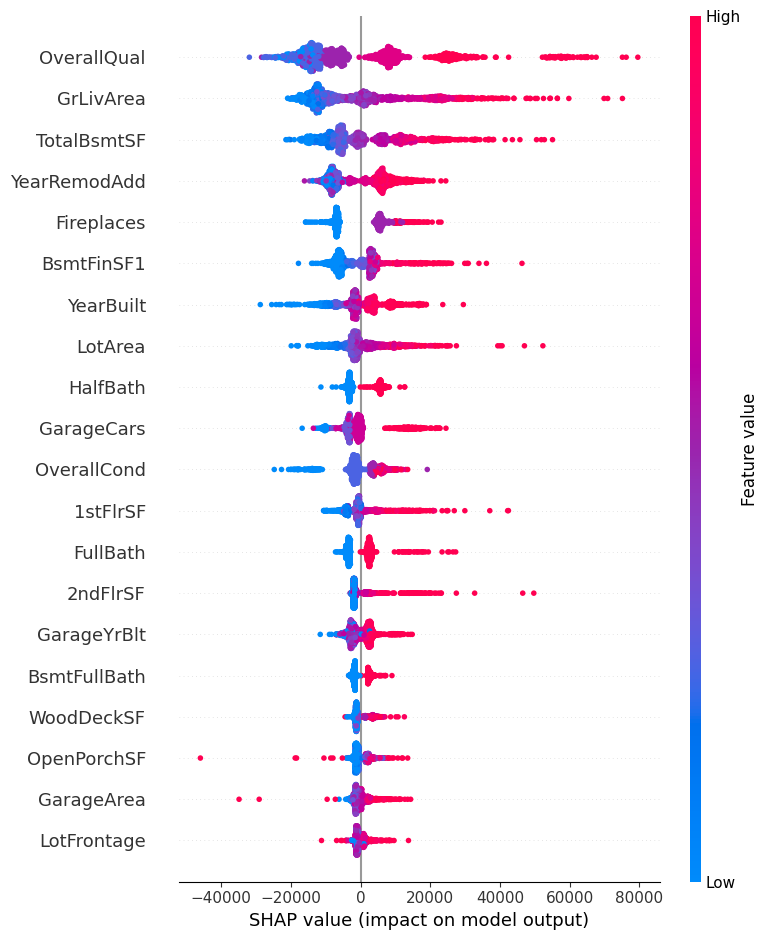

In [91]:
shap.summary_plot(shap_values, X_num)

In [92]:
res = ['BsmtFullBath', 'WoodDeckSF', 'OpenPorchSF', 'HalfBath']

Garagearea проверить на выброс

In [93]:
cor_result = ['Id', 'MiscVal', 'BsmtHalfBath', 'BsmtFinSF2', 'MoSold', '3SsnPorch', 'YrSold', 'LowQualFinSF']
cor_result = set(cor_result)
res1 = ['MoSold', '3SsnPorch', 'YrSold', 'LowQualFinSF', 'Id', 'MiscVal', 'BsmtHalfBath', 'BsmtFinSF2']
res1 = set(res1)

res2 = ['OpenPorchSF', 'Id', 'MiscVal', 'LotArea', 'GarageArea']
res2 = set(res2)

res3 = ['BsmtFullBath', 'WoodDeckSF', 'OpenPorchSF', 'HalfBath']
res3 = set(res3)

fromcor = ['GarageCars', 'totalrmsabvgrd', 'Total bsmtSF', 'Garageyearbuild']
fromcor = set(fromcor)
union = cor_result.union(res1, res2, res3, fromcor)
union

{'3SsnPorch',
 'BsmtFinSF2',
 'BsmtFullBath',
 'BsmtHalfBath',
 'GarageArea',
 'GarageCars',
 'Garageyearbuild',
 'HalfBath',
 'Id',
 'LotArea',
 'LowQualFinSF',
 'MiscVal',
 'MoSold',
 'OpenPorchSF',
 'Total bsmtSF',
 'WoodDeckSF',
 'YrSold',
 'totalrmsabvgrd'}

In [94]:
X_train['HouseAge'] = 2020 - X_train['YearBuilt']
X_valid['HouseAge'] = 2020 - X_valid['YearBuilt']
X_train['RemodAge'] = 2020 - X_train['YearRemodAdd']
X_valid['RemodAge'] = 2020 - X_valid['YearRemodAdd']

# 1. РЕМОНТ
X_train['IsOldNotRemod'] = ((X_train['HouseAge'] > 50) &
                              (X_train['RemodAge'] == X_train['HouseAge'])).astype(int)
X_valid['IsOldNotRemod'] = ((X_valid['HouseAge'] > 50) &
                            (X_valid['RemodAge'] == X_valid['HouseAge'])).astype(int)

# Качество × площадь = OverallQual × GrLivArea.

# 11. РАЗНИЦА КАЧЕСТВА И СОСТОЯНИЯ
X_train['QualCondDiff'] = X_train['OverallQual'] - X_train['OverallCond']
X_valid['QualCondDiff'] = X_valid['OverallQual'] - X_valid['OverallCond']

# 12. ЕСТЬ ГАРАЖ (бинарная фича)
X_train['HasGarage'] = (X_train['GarageArea'] > 0).astype(int)
X_valid['HasGarage'] = (X_valid['GarageArea'] > 0).astype(int)

# 13. ЕСТЬ ПОДВАЛ
X_train['HasBsmt'] = (X_train['TotalBsmtSF'] > 0).astype(int)
X_valid['HasBsmt'] = (X_valid['TotalBsmtSF'] > 0).astype(int)


# 14. ПЛОЩАДЬ УЧАСТКА НА ПЛОЩАДЬ ДОМА
X_train['LotRatio'] = X_train['LotArea'] / X_train['GrLivArea']
X_valid['LotRatio'] = X_valid['LotArea'] / X_valid['GrLivArea']
X_train['LotRatio'] = X_train['LotRatio'].replace([np.inf, -np.inf], 0)
X_valid['LotRatio'] = X_valid['LotRatio'].replace([np.inf, -np.inf], 0)

In [95]:
X_train = X_train.drop(columns='Id', errors='ignore')

# cols_to_drop = ['3SsnPorch', 'BsmtFinSF2', 'BsmtFullBath', 'BsmtHalfBath',
#     'GarageCars', 'GarageYrBlt', 'HalfBath', 'LowQualFinSF',
#     'MiscVal', 'MoSold', 'OpenPorchSF', 'TotalBsmtSF',
#     'WoodDeckSF', 'YrSold', 'TotRmsAbvGrd']
# X_train = X_train.drop(columns=cols_to_drop, errors='ignore')
# X_valid = X_valid.drop(columns=cols_to_drop, errors='ignore')
# if 'SalePrice' in X_train.columns:
#     sale_price_mean = X_train['SalePrice'].mean()
#     X_train.loc[X_train['SalePrice'] > 500000, 'SalePrice'] = sale_price_mean
# X_train.loc[X_train['LotArea'] > 500000, 'LotArea'] = 500000
# X_valid.loc[X_valid['LotArea'] > 500000, 'LotArea'] = 500000
# print(X_train.shape)
# print(X_valid.shape)
# print(cols_to_drop)

In [96]:
cat_f = X_train.select_dtypes(include='object').columns
id = [X_train.columns.get_loc(col) for col in cat_f]
id

[1,
 4,
 5,
 6,
 7,
 8,
 9,
 10,
 11,
 12,
 13,
 14,
 15,
 20,
 21,
 22,
 23,
 24,
 26,
 27,
 28,
 29,
 30,
 31,
 32,
 34,
 38,
 39,
 40,
 41,
 52,
 54,
 56,
 57,
 59,
 62,
 63,
 64,
 71,
 72,
 73,
 77,
 78]

In [97]:


# preprocessor = ColumnTransformer(
#     [
#         ('ohe_hot_coder', OneHotEncoder(sparse_output=False), one_hot_coder),
#         ('target_coder', TargetEncoder(), target_coder),
        
#     ],
#     verbose_feature_names_out = False,
#     remainder = 'passthrough'
# )

model = CatBoostRegressor(iterations=1500, learning_rate=0.05, depth=6, l2_leaf_reg=8, random_seed=42, early_stopping_rounds=50, verbose=0, cat_features=id)




ml2_pipeline = Pipeline(
    [
        ('model', model)   
    ]
)

y_train_log = np.log1p(y_train)



In [98]:

from sklearn.ensemble import ExtraTreesRegressor, HistGradientBoostingRegressor
from sklearn.linear_model import Ridge, Lasso, ElasticNet, RidgeCV
from sklearn.svm import SVR
from sklearn.neighbors import KNeighborsRegressor
from catboost import CatBoostRegressor
from lightgbm import LGBMRegressor
from xgboost import XGBRegressor
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import StackingRegressor


preprocessor = ColumnTransformer(
    [
        ('ohe_hot_coder', OneHotEncoder(sparse_output=False), one_hot_coder),
        ('target_coder', TargetEncoder(), target_coder),
        
    ],
    verbose_feature_names_out = False,
    remainder = 'passthrough'
)

# ----------------------------
# Числовые модели (линейные, соседи, SVM)
# ----------------------------
linear_models = [
    ('ridge', make_pipeline(StandardScaler(), Ridge(alpha=1.0))),
    ('lasso', make_pipeline(StandardScaler(), Lasso(alpha=0.01, max_iter=2000))),
    ('elastic', make_pipeline(StandardScaler(), ElasticNet(alpha=0.01, l1_ratio=0.5, max_iter=2000))),
    ('svr', make_pipeline(StandardScaler(), SVR(C=1.0, epsilon=0.1, gamma='scale'))),
    ('knn', make_pipeline(StandardScaler(), KNeighborsRegressor(n_neighbors=15))),
]

# ----------------------------
# Деревья и бустинги (разные архитектуры)
# ----------------------------
tree_models = [
    # CatBoost — устойчив к категориям и выбросам
    ('catboost', CatBoostRegressor(
        iterations=3000,
        learning_rate=0.01,
        max_depth=5,
        l2_leaf_reg=3,
        random_strength=1,
        bagging_temperature=0.2,
        verbose=0,
        random_state=42
    )),
    
    # LightGBM — быстрый, лист-ориентированный
    ('lgbm', LGBMRegressor(
        n_estimators=800,
        learning_rate=0.03,
        max_depth=5,
        num_leaves=31,
        subsample=0.8,
        colsample_bytree=0.8,
        reg_alpha=0.1,
        reg_lambda=0.1,
        min_data_in_leaf=20,
        random_state=42,
    )),
    
    # XGBoost — мощный, регуляризованный
    ('xgb', XGBRegressor(
        n_estimators=800,
        learning_rate=0.03,
        max_depth=5,
        subsample=0.8,
        colsample_bytree=0.8,
        reg_alpha=0.1,
        reg_lambda=1.0,
        random_state=42,
        verbosity=0
    )),
    
    # Random Forest — низкая корреляция с бустингами
    ('rf', RandomForestRegressor(
        n_estimators=500,
        max_depth=8,
        min_samples_split=5,
        min_samples_leaf=2,
        max_features='sqrt',
        random_state=42,
        n_jobs=-1
    )),
    
    # Extra Trees — ещё менее переобучается, чем RF
    ('et', ExtraTreesRegressor(
        n_estimators=500,
        max_depth=8,
        min_samples_split=5,
        min_samples_leaf=2,
        max_features='sqrt',
        random_state=42,
        n_jobs=-1
    )),
    
    # Histogram-based GB (от sklearn) — другой алгоритм
    ('rf_deep', RandomForestRegressor(
    n_estimators=400,
    max_depth=None,          # ← без ограничения глубины!
    min_samples_split=2,
    min_samples_leaf=1,
    max_features=0.5,        # ← не 'sqrt', а часть признаков
    bootstrap=True,
    oob_score=False,
    random_state=42,
    n_jobs=-1
))
]

# Объединяем все модели
all_base_models = linear_models + tree_models

# Мета-модель: Ridge — простая, устойчивая, не переобучается
# meta_model = LGBMRegressor(n_estimators=100, max_depth=3, learning_rate=0.1)
meta_model = RidgeCV(alphas=np.logspace(-3, 3, 20))

# Стекинг
stacking_regressor = StackingRegressor(
    estimators=all_base_models,
    final_estimator=meta_model,
    cv=5,                # обязательно! избегаем утечки
    n_jobs=-1,
    passthrough=False    # не добавляем исходные признаки (модели и так сильные)
)

ml_stack_pipe = Pipeline(
    [
        ('preprocessor', preprocessor),
        ('stack', stacking_regressor)
    ]
)

In [99]:
ml_stack_pipe.fit(X_train, y_train_log)

[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=20
[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=20
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.011141 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 4568
[LightGBM] [Info] Number of data points in the train set: 1460, number of used features: 89
[LightGBM] [Info] Start training from score 12.024057
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positi

,steps,"[('preprocessor', ...), ('stack', ...)]"
,transform_input,None
,memory,None
,verbose,False
,transformers,"[('ohe_hot_coder', ...), ('target_coder', ...)]"
,remainder,'passthrough'
,sparse_threshold,0.3
,n_jobs,None
,transformer_weights,None
,verbose,False
,verbose_feature_names_out,False


In [100]:
# Предсказание и обратное преобразование

# Вывод первых 10 предсказаний
from sklearn.metrics import mean_squared_error

# Так как y_train_log = log1p(y_train), предсказания тоже в log1p-шкале
y_pred_log = ml_stack_pipe.predict(X_train)

# RMSLE = RMSE на логарифмах
rmsle = np.sqrt(mean_squared_error(y_train_log, y_pred_log))
print(f"RMSLE: {rmsle:.4f}")

[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=20
RMSLE: 0.0612


/Users/igor/miniforge3/lib/python3.12/site-packages/sklearn/utils/validation.py:2742: UserWarning: X has feature names, but RidgeCV was fitted without feature names
  warnings.warn(


In [101]:
y_pred_log = ml_stack_pipe.predict(X_valid)

[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=20


/Users/igor/miniforge3/lib/python3.12/site-packages/sklearn/utils/validation.py:2742: UserWarning: X has feature names, but RidgeCV was fitted without feature names
  warnings.warn(


In [102]:
y_pred = np.expm1(y_pred_log)


y_pred = pd.Series(
    y_pred,
    index=range(1461,2920),  # ← используем реальные Id из данных
    name='SalePrice')
y_pred.index.name = 'Id'
y_pred

Id
1461    125749.437238
1462    158539.039762
1463    185110.669187
1464    194508.713935
1465    186279.582186
            ...      
2915     82549.287914
2916     81529.475473
2917    160657.052731
2918    116355.893827
2919    211437.210300
Name: SalePrice, Length: 1459, dtype: float64

In [103]:
y_pred.to_csv('res4.csv')

In [104]:
joblib.dump(ml_stack_pipe, 'house_price_model.pkl')

['house_price_model.pkl']